<a href="https://colab.research.google.com/github/andreidm92/computer_vision_tasks/blob/main/practice/Lesson_26_SAM_video_depth_linalg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Урок 26: Сегментация видео через SAM + Параллакс и глубина


## 🎯 Часть 1: Теория Segment Anything Model (SAM)

**SAM (Segment Anything Model)** — это мощная модель сегментации изображений от Meta AI. Она использует prompt-подход: вы указываете область интереса (точка, рамка, маска), а SAM возвращает маску объекта.

**Ключевые возможности SAM:**
- Сегментация на основе input prompt (точка, bbox).
- Высокое качество сегментации на разнообразных данных.
- Визуализация и анализ результатов.

В этом уроке мы будем использовать SAM на **видео**: сегментируем объект в первом кадре и отслеживаем его маску по остальным кадрам.


In [1]:

# Установка SAM и зависимостей (если нужно)
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install opencv-python matplotlib

import cv2
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor
from PIL import Image


  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-6h62nf3e
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-6h62nf3e
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=34391338961a387add2cf0a81ca208da05db8ea4721cbff3428d3d38e8a3bbcb
  Stored in directory: /tmp/pip-ephem-wheel-cache-_z11xvmh/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything


In [3]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth


--2025-05-24 21:35:01--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.10, 13.227.219.70, 13.227.219.59, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b_01ec64.pth’

sam_vit_b_01ec64.pt 100%[===================>] 357.67M   228MB/s    in 1.6s    

2025-05-24 21:35:02 (228 MB/s) - ‘sam_vit_b_01ec64.pth’ saved [375042383/375042383]



In [4]:

# Загрузка модели SAM (предполагается, что у вас есть checkpoint)
sam_checkpoint = "/content/sam_vit_b_01ec64.pth"  # замените на путь к вашей модели
model_type = "vit_b"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
predictor = SamPredictor(sam)


In [5]:

# Загрузка видео
video_path = "/content/woman.mp4"  # Замените на путь к вашему видео
cap = cv2.VideoCapture(video_path)

frames = []
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
cap.release()

print(f"Загружено {len(frames)} кадров")


Загружено 216 кадров


Размер первого кадра: (1280, 720, 3)


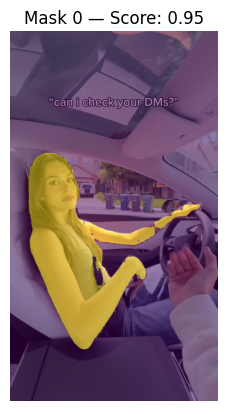

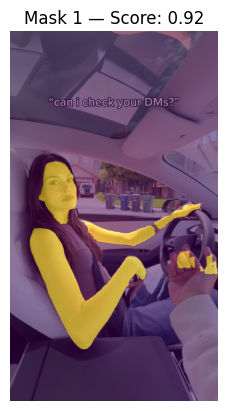

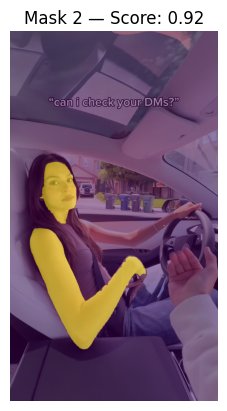

In [10]:

# Выбор первого кадра и указание точки для сегментации
first_frame = frames[0]
print(f"Размер первого кадра: {first_frame.shape}")
predictor.set_image(first_frame)

# Пример: точка внутри объекта (x, y)
input_point = np.array([[110, 700]])
input_label = np.array([1])  # woman

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

# Отображение масок
for i, mask in enumerate(masks):
    plt.imshow(first_frame)
    plt.imshow(mask, alpha=0.5)
    plt.title(f"Mask {i} — Score: {scores[i]:.2f}")
    plt.axis('off')
    plt.show()

selected_mask = masks[0]


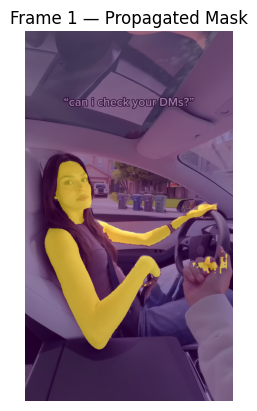

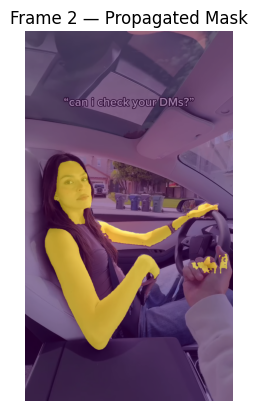

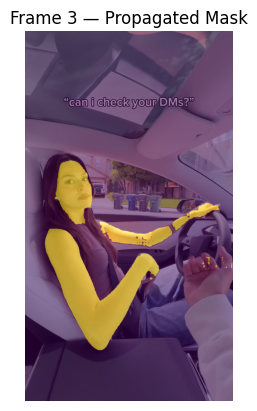

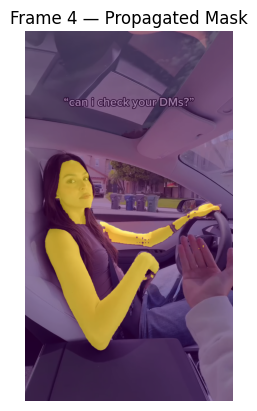

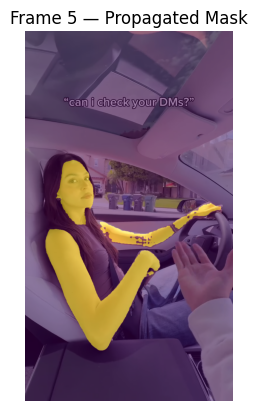

In [11]:
# Использование той же точки в других кадрах — упрощённый анализ стабильности SAM
for i, frame in enumerate(frames[1:6]):
    predictor.set_image(frame)
    masks, _, _ = predictor.predict(point_coords=input_point, point_labels=input_label, multimask_output=False)
    plt.imshow(frame)
    plt.imshow(masks[0], alpha=0.5)
    plt.title(f"Frame {i+1} — Propagated Mask")
    plt.axis('off')
    plt.show()


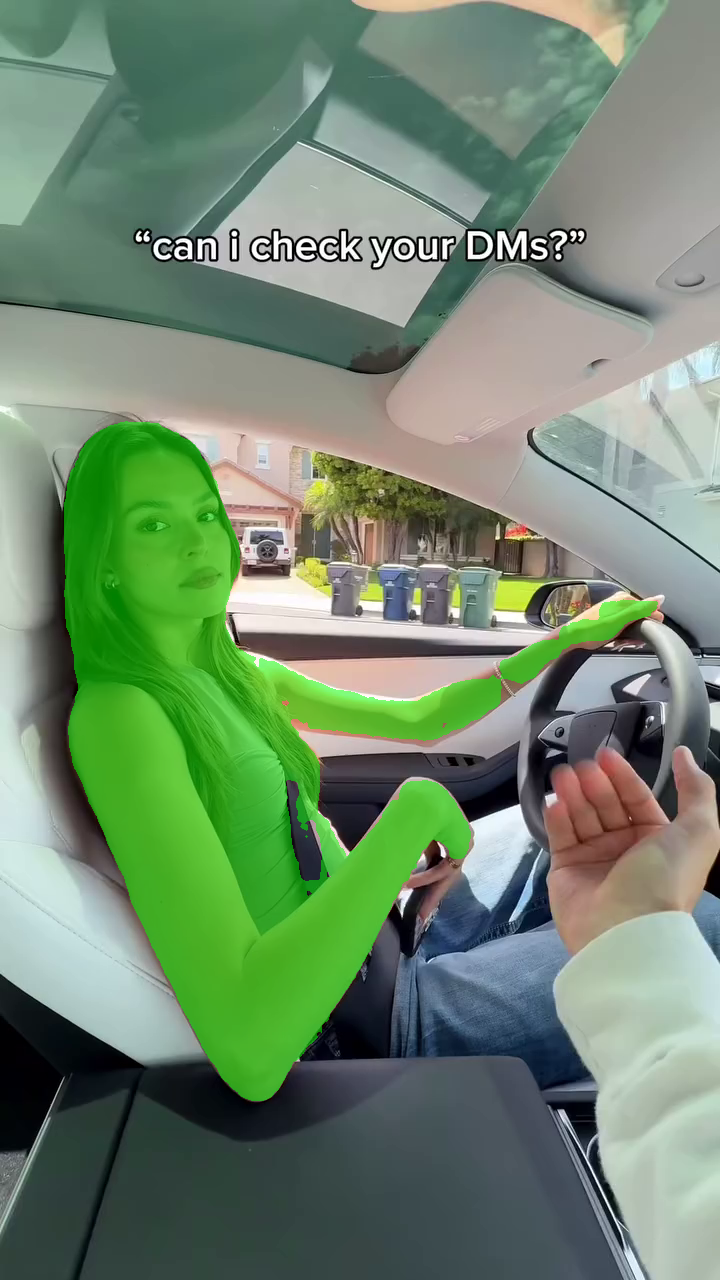

In [13]:
from google.colab.patches import cv2_imshow

# Alpha blending для наложения маски
def apply_mask(image, mask, color=(0, 255, 0), alpha=0.5):
    overlay = image.copy()
    overlay[mask == 1] = color
    return cv2.addWeighted(image, 1 - alpha, overlay, alpha, 0)

blended = apply_mask(cv2.cvtColor(first_frame, cv2.COLOR_RGB2BGR), selected_mask)
cv2_imshow(blended)




## 📐 Часть 2: Линейная алгебра — Параллакс и триангуляция

Когда мы смотрим на объект с двух разных позиций (две камеры), объекты на фоне и переднем плане смещаются по-разному. Это смещение называется **параллакс**.

**Формула вычисления глубины через параллакс:**

$$
Z = \frac{f \cdot B}{d}
$$

Где:
- \( Z \) — глубина (расстояние до объекта),
- \( f \) — фокусное расстояние (в пикселях),
- \( B \) — расстояние между камерами (baseline),
- \( d \) — параллакс (разница между координатами объекта на левом и правом изображении).

Чем больше параллакс — тем ближе объект.


In [14]:

# Пример: расчет глубины
f = 800  # фокусное расстояние в пикселях
B = 0.1  # расстояние между камерами (в метрах)
d = 10   # разница координат объекта (в пикселях)

Z = (f * B) / d
print(f"Расстояние до объекта: {Z:.3f} м")


Расстояние до объекта: 8.000 м


🔹 Расчёт ( f ) — фокусного расстояния в пикселях
Если известна физическая информация о сенсоре и объективе:

fpx=fmm⋅wpxwmm

( f_{\text{mm}} ) — фокусное расстояние объектива в миллиметрах,
( w_{\text{px}} ) — ширина изображения в пикселях,
( w_{\text{mm}} ) — ширина сенсора в миллиметрах.

In [ ]:
# Пример: пересчёт f из миллиметров в пиксели
f_mm = 3.6  # мм
sensor_width_mm = 4.8  # мм
image_width_px = 640  # пикселей

f_px = f_mm * image_width_px / sensor_width_mm
print(f"Фокусное расстояние в пикселях: {f_px:.2f}")

🔹 ( B ) — базовая линия
Это расстояние между центрами двух камер. Для разных устройств:

WebCam-стерео: 6.0 см (0.06 м),
Intel RealSense: 5.0 см (0.05 м),
iPhone двойная камера: 3.0 см (0.03 м).
Это фиксированная константа и должна быть известна заранее или измерена вручную.



# 🔹 \( d \) — параллакс

Разность координат одного и того же объекта на левом и правом изображении:

$$
d = x_L - x_R
$$

Чтобы получить disparity карту автоматически, можно использовать OpenCV:

```python
stereo = cv2.StereoBM_create(numDisparities=64, blockSize=15)
disparity = stereo.compute(left_gray, right_gray)
d = disparity[y, x] / 16  # делим на 16, так как OpenCV масштабирует значения
```


🔹 ( d ) — параллакс
Разность координат одного и того же объекта на левом и правом изображении:

d=xL−xR

Чтобы получить disparity карту автоматически, можно использовать OpenCV:

stereo = cv2.StereoBM_create(numDisparities=64, blockSize=15)
disparity = stereo.compute(left_gray, right_gray)
d = disparity[y, x] / 16  # делим на 16, так как OpenCV масштабирует значения



In [ ]:

# Пример итогового расчёта глубины
f_px = 800  # фокусное расстояние в пикселях
B = 0.1     # расстояние между камерами в метрах
d = 10      # параллакс в пикселях

Z = (f_px * B) / d
print(f"Расстояние до объекта: {Z:.3f} м")

✅ Вывод
Чтобы автоматически вычислить глубину:

Получи ( f ) через параметры сенсора и изображения.
Измерь или знай базовую линию ( B ).
Построй карту disparity через OpenCV.
Подставь значения в формулу ( Z = \frac{f \cdot B}{d} ).

✅ Теперь ты готов использовать SAM для сегментации видео и вычислять глубину через параллакс!